In [1]:
#conectamos con google drive para poder leer el fichero csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importaciones necesraias para hacer el ejercicio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1


import warnings
warnings.filterwarnings("ignore")

In [3]:
#Leemos el fichero csv
df=pd.read_csv('/content/drive/MyDrive/AprendizajeAutomatico/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Series temporales (análisis exploratorio y preparar los datos para el modelado)

**Analisis preliminar**

In [4]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [5]:
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [7]:
# vemos cuantos valores nulos tenemos de cada variable
df.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

Como tenemos tantos valores nulos y en todas las columnas son los mismos vamos a eliminar estas filas con estos datos(Timestamp y vacios), esto lo podemos hacer ya que la unica columna con datos no vacios es Timestamp que es la fecha que no nos va a aportar nada para el entrenamiento. Otra opcion que tendriamos seria rellernalos con la media pero para este caso no  es lo mas oportuno ya que son muchisimas las filas del dataset que tienen todos los valores nulos exceptuando Timestamp( la fecha).

In [8]:
df.dropna(inplace=True)

In [9]:
#vemos que hemos emilinado las filas con todo valores nulos menos Timestamp
df.isnull().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

**Manipulación de la Serie Temporal**

In [10]:
# Ponemos la varible 'Timestamp' esté en formato de fecha y tiempo.
# el argumento unit='s', lo que indica que los valores en la columna 'Timestamp' se interpretarán como marcas de tiempo en segundos
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')

In [11]:
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [12]:
# Creamos dos nuevas columnas una con el año y una con el mes esto sera util a la hora de dividir los datos
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month

In [13]:
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011,12
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011,12
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011,12
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011,12
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012,1
...,...,...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021,3
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021,3
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021,3
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021,3


**Visualizacion de los datos**

Text(0.5, 1.0, 'Volumen de Bitcoin a lo largo del tiempo')

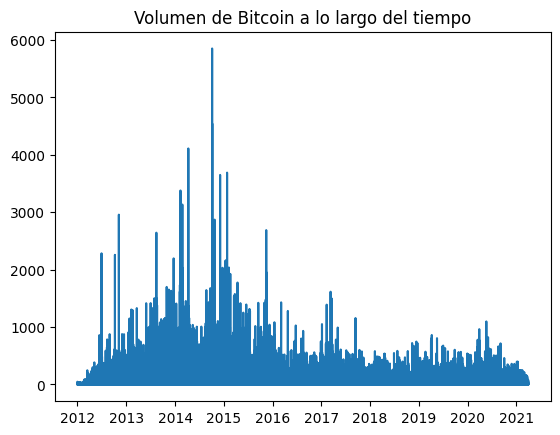

In [14]:
# Gráfica de volumen
plt.plot(df['Timestamp'], df['Volume_(BTC)'])
plt.title('Volumen de Bitcoin a lo largo del tiempo')

Esta gráfica la hemos hecho por visualizar los datos, la importante es la que viene ahora.

Text(0.5, 1.0, 'Precio de Cierre a lo largo del tiempo')

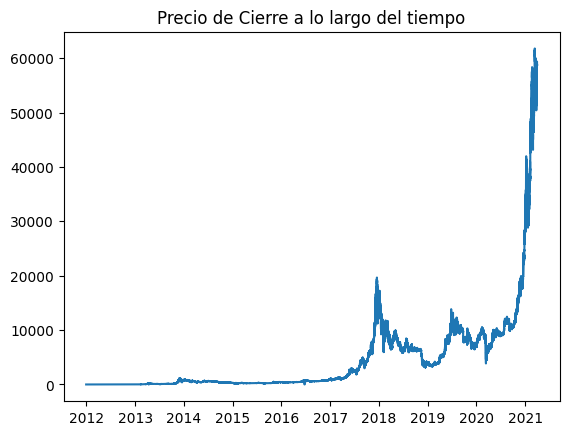

In [15]:
# Gráfica de precios de cierre
plt.plot(df['Timestamp'], df['Close'])
plt.title('Precio de Cierre a lo largo del tiempo')

En la grafica podemos observar que el valor que tiene el Bitcoin los primeros años es muy similar y tiene el precio muy bajo comparandolo con a partir de 2017 y esto lo unico que hara es entorpezernos nuestro entrenamiento por lo que vamos a considerar para el conjunto de entranamiento
del año 2017 a la mitad de 2020 y para el conjunto de test la mitad del 2020 y el 2021

**Separamos los datos en train y test y hacemos un escalado**


In [16]:
X_train = df[['Open', 'High', 'Low','Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']][df['Timestamp'].between(pd.to_datetime('2017-01-01 00:00:00'),pd.to_datetime('2020-06-30 00:00:00'))]
y_train = df[['Close']][df['Timestamp'].between(pd.to_datetime('2017-01-01 00:00:00'),pd.to_datetime('2020-06-30 00:00:00'))]

X_test = df[[ 'Open', 'High', 'Low','Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']][df['Timestamp']>pd.to_datetime('2020-06-30 00:00:00')]
y_test = df[['Close']][df['Timestamp']>pd.to_datetime('2020-06-30 00:00:00')]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(1754137, 7) (1754137, 1)
(390228, 7) (390228, 1)


In [17]:
scaler = StandardScaler()
sc = scaler.fit(X_train)

train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(test_sc)
X_test_sc.columns = X_test.columns

print(X_train_sc.shape, y_train.shape)
print(X_test_sc.shape, y_test.shape)

(1754137, 7) (1754137, 1)
(390228, 7) (390228, 1)


In [18]:
# Esta función agrupa los instantes de tiempo en bloques de tamaño `time_steps`
# Reorganizamos el dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
      v = X.iloc[i:(i + time_steps)].values
      Xs.append(v)
      ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [19]:
time_steps = 12

X_train_shape, y_train_shape = create_dataset(X_train_sc, y_train, time_steps)
X_test_shape, y_test_shape = create_dataset(X_test_sc, y_test, time_steps)

print(X_train_shape.shape, y_train.shape)
print(X_test_shape.shape, y_test.shape)



(1754125, 12, 7) (1754137, 1)
(390216, 12, 7) (390228, 1)


## Redes neuronales recurrentes ##

Las redes neuronales recurrentes (RNNs) son una clase de redes neuronales que son poderosas para modelar secuencias de datos, como el lenguaje natural o las series temporales. A diferencia de las redes neuronales tradicionales, las RNN tienen conexiones en bucle que les permiten mantener información en la memoria durante un tiempo. Aquí hay algunos puntos clave sobre las RNN:

1.Memoria a corto plazo: Las RNN pueden usar su memoria para procesar secuencias de entradas. Esto las hace adecuadas para tareas como el reconocimiento de voz o la predicción de series temporales.

2.Arquitectura: En una RNN, cada nodo de una capa está conectado con todos los nodos de la capa siguiente y con los nodos de su propia capa, lo que crea un bucle en la red. Esto permite que la información de una entrada anterior sea usada para influir en la salida actual.

3.Problemas: Las RNN tradicionales sufren de lo que se conoce como los problemas de dependencias a largo plazo, donde se hace difícil para la red aprender a conectar la información con puntos de datos que están muy alejados en la secuencia.

4.Variantes: Para superar estos problemas, se han desarrollado variantes como la LSTM (Long Short-Term Memory) y la GRU (Gated Recurrent Unit), que son capaces de retener información a largo plazo con un diseño que permite que la información fluya a través de la red sin ser transformada de manera significativa.

5.Aplicaciones: Las RNN se utilizan en una variedad de aplicaciones, como el procesamiento del lenguaje natural, la generación de texto, la traducción automática, y el análisis de sentimiento. También son útiles en el modelado de series temporales para pronósticos financieros, patrones climáticos y más.

6.Entrenamiento: El entrenamiento de una RNN se realiza a través de un proceso conocido como backpropagation through time (BPTT), una variante del algoritmo de retropropagación utilizado en redes neuronales tradicionales.

Las RNN han sido un gran avance en el campo del aprendizaje automático y el procesamiento del lenguaje natural, permitiendo modelos computacionales que se acercan más a la capacidad humana de entender y producir lenguaje.







In [22]:
model1_rnn=Sequential()
model1_rnn.add(SimpleRNN(32,activation='relu',  input_shape = (X_train_shape.shape[1], X_train_shape.shape[2]),kernel_regularizer=l1(0.01)))
model1_rnn.add(Dense(1))

model1_rnn.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_model1_rnn = model1_rnn.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape),steps_per_epoch=1000, epochs=15, batch_size = 32)


Epoch 1/15
1000/1000 [==============================] - 31s 30ms/step - loss: 5516887.0000 - mean_absolute_error: 1091.6508 - mean_absolute_percentage_error: 23.1931 - val_loss: 5038625.5000 - val_mean_absolute_error: 1342.7155 - val_mean_absolute_percentage_error: 3.4690
Epoch 2/15
1000/1000 [==============================] - 44s 44ms/step - loss: 16778.9160 - mean_absolute_error: 80.8529 - mean_absolute_percentage_error: 1.7164 - val_loss: 3468417.0000 - val_mean_absolute_error: 1063.2999 - val_mean_absolute_percentage_error: 2.5600
Epoch 3/15
1000/1000 [==============================] - 26s 26ms/step - loss: 10865.2871 - mean_absolute_error: 69.2887 - mean_absolute_percentage_error: 1.4792 - val_loss: 2299860.7500 - val_mean_absolute_error: 834.9446 - val_mean_absolute_percentage_error: 1.9760
Epoch 4/15
1000/1000 [==============================] - 33s 33ms/step - loss: 10348.6367 - mean_absolute_error: 65.3570 - mean_absolute_percentage_error: 1.4125 - val_loss: 1013026.6250 - val_

In [23]:
#evaluamos el modelo
ypred_model1_rnn = model1_rnn.predict(X_test_shape)

_, mae_tr, mape_tr = model1_rnn.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = model1_rnn.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

12195/12195 [==============================] - 36s 3ms/step - loss: 136083.1562 - mean_absolute_error: 228.2744 - mean_absolute_percentage_error: 0.6986
MAE train: 28.65; MAPE train: 0.51
MAE test: 228.27; MAPE test: 0.70


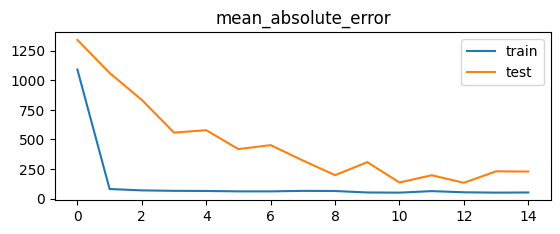

In [24]:
#vemos la grafica de entrenamiento
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_model1_rnn.history['mean_absolute_error'], label='train')
plt.plot(history_model1_rnn.history['val_mean_absolute_error'], label='test')
plt.legend()

Ahora vamos a mejorar el modelo añadiendole mas capas y dropout para evitar el sobre ajuste y todo esto para intentar mejorar el resultado

In [20]:
model2_rnn=Sequential()
model2_rnn.add(SimpleRNN(32,activation='relu',  input_shape = (X_train_shape.shape[1], X_train_shape.shape[2]),kernel_regularizer=l1(0.01), return_sequences= True))
model2_rnn.add(Dropout(0.2))
model2_rnn.add(SimpleRNN(16,activation='relu',  kernel_regularizer=l1(0.01)))
model2_rnn.add(Dropout(0.2))
model2_rnn.add(Dense(1))

model2_rnn.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_model2_rnn = model2_rnn.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape),steps_per_epoch=1000, epochs=15, batch_size = 32)

Epoch 1/15
1000/1000 [==============================] - 50s 48ms/step - loss: 7929366.0000 - mean_absolute_error: 1829.3101 - mean_absolute_percentage_error: 29.8379 - val_loss: 1275738.7500 - val_mean_absolute_error: 963.7449 - val_mean_absolute_percentage_error: 5.3977
Epoch 2/15
1000/1000 [==============================] - 36s 36ms/step - loss: 1900689.1250 - mean_absolute_error: 990.0417 - mean_absolute_percentage_error: 15.2446 - val_loss: 9874625.0000 - val_mean_absolute_error: 2013.3478 - val_mean_absolute_percentage_error: 5.8551
Epoch 3/15
1000/1000 [==============================] - 35s 35ms/step - loss: 1863041.3750 - mean_absolute_error: 983.1205 - mean_absolute_percentage_error: 15.1830 - val_loss: 2829859.0000 - val_mean_absolute_error: 1178.9749 - val_mean_absolute_percentage_error: 4.6499
Epoch 4/15
1000/1000 [==============================] - 36s 36ms/step - loss: 1877917.1250 - mean_absolute_error: 985.0094 - mean_absolute_percentage_error: 15.1077 - val_loss: 1864490

In [21]:
#evaluamos el modelo
ypred_model2_rnn = model2_rnn.predict(X_test_shape)

_, mae_tr, mape_tr = model2_rnn.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = model2_rnn.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

12195/12195 [==============================] - 36s 3ms/step - loss: 401524.8125 - mean_absolute_error: 586.0413 - mean_absolute_percentage_error: 2.9898
MAE train: 314.55; MAPE train: 5.22
MAE test: 586.04; MAPE test: 2.99


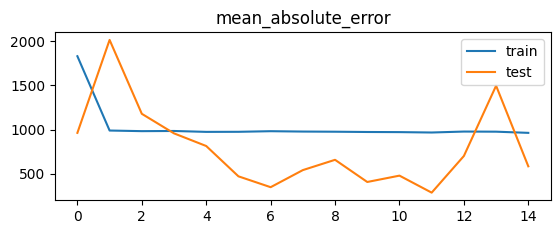

In [22]:
#vemos la grafica de entrenamiento
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_model2_rnn.history['mean_absolute_error'], label='train')
plt.plot(history_model2_rnn.history['val_mean_absolute_error'], label='test')
plt.legend()

Viendo ambos casos vemos que la red más simple model1_rnn es la más adecuada para los datos y la tarea específica, lo que lleva a un entrenamiento más efectivo. El modelo más complejo model2_rnn es demasiado complejo para el problema en cuestión. Además, las complejidades añadidas en model2_rnn podrían hacer que el modelo requiera más datos o más tiempo de entrenamiento para alcanzar su potencial.

## Redes LSTM ##

Las redes LSTM (Long Short-Term Memory) son una mejora especializada de las redes neuronales recurrentes (RNN) que fueron diseñadas para superar el problema de dependencia a largo plazo que presentan las RNN tradicionales. Aquí hay algunos puntos clave sobre las redes LSTM:

1.Memoria a largo plazo: Las LSTM están diseñadas para recordar información durante largos periodos de tiempo gracias a su estructura interna de puertas (gates). Esto les permite mantener la información relevante y descartar la no relevante a lo largo de la secuencia de datos.

2.Estructura de puertas: Las LSTM tienen una estructura de celdas con tres tipos de puertas:

-Puerta de olvido (forget gate): Decide qué información es irrelevante y puede ser descartada.

-Puerta de entrada (input gate): Actualiza el estado de la celda con información nueva.

-Puerta de salida (output gate): Determina qué parte del estado de la celda se debe pasar a la salida.

3.Estado de la celda: En el corazón de una LSTM se encuentra el estado de la celda, que es una especie de "transportador" que lleva la información relevante a través de la secuencia de datos. Las puertas controlan el flujo de información dentro y fuera del estado de la celda.

4.Backpropagation Through Time (BPTT): Al igual que con las RNN, las LSTM se entrenan utilizando una versión modificada de backpropagation llamada BPTT, donde los gradientes se propagan hacia atrás a través del tiempo y de las secuencias para actualizar los pesos.

5.Ventajas sobre RNN tradicionales: Las LSTM pueden manejar secuencias más largas de datos sin perder rendimiento, lo que las hace muy efectivas para problemas de procesamiento de lenguaje natural, reconocimiento de voz, y más.

6.Aplicaciones: Las LSTM se utilizan ampliamente en aplicaciones que requieren el modelado de secuencias, incluyendo traducción automática, generación de texto, y reconocimiento de voz. También son útiles para predecir series temporales en finanzas y otros campos.

7.Variantes: Existen varias variantes de las LSTM, como las LSTM apiladas, las LSTM bidireccionales y las LSTM con atención, que mejoran la capacidad de la red para aprender de secuencias complejas y relaciones a largo plazo.

Las LSTM han sido fundamentales en el avance de muchos sistemas de aprendizaje automático debido a su capacidad para capturar dependencias temporales y su habilidad para trabajar con secuencias de longitud variable.







In [23]:
model1_LSTM=Sequential()
model1_LSTM.add(LSTM(32,activation='relu',  input_shape = (X_train_shape.shape[1], X_train_shape.shape[2]),kernel_regularizer=l1(0.01)))
model1_LSTM.add(Dense(1))

model1_LSTM.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_model1_LSTM = model1_LSTM.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape),steps_per_epoch=1000, epochs=15, batch_size = 32)

Epoch 1/15
1000/1000 [==============================] - 50s 49ms/step - loss: 4650345.0000 - mean_absolute_error: 870.8381 - mean_absolute_percentage_error: 16.0390 - val_loss: 8685855.0000 - val_mean_absolute_error: 1543.5900 - val_mean_absolute_percentage_error: 3.5052
Epoch 2/15
1000/1000 [==============================] - 47s 47ms/step - loss: 14016.4551 - mean_absolute_error: 74.8291 - mean_absolute_percentage_error: 1.4984 - val_loss: 6090888.0000 - val_mean_absolute_error: 1293.0868 - val_mean_absolute_percentage_error: 2.9687
Epoch 3/15
1000/1000 [==============================] - 48s 48ms/step - loss: 8357.1113 - mean_absolute_error: 60.5148 - mean_absolute_percentage_error: 1.2436 - val_loss: 7746075.0000 - val_mean_absolute_error: 1434.6566 - val_mean_absolute_percentage_error: 3.1352
Epoch 4/15
1000/1000 [==============================] - 35s 35ms/step - loss: 5688.4678 - mean_absolute_error: 52.4098 - mean_absolute_percentage_error: 1.0701 - val_loss: 7684137.5000 - val_me

In [24]:
#evaluamos el modelo
ypred_model1_LSTM = model1_LSTM.predict(X_test_shape)

_, mae_tr, mape_tr = model1_LSTM.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = model1_LSTM.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

12195/12195 [==============================] - 35s 3ms/step - loss: 5066670.0000 - mean_absolute_error: 1208.5500 - mean_absolute_percentage_error: 2.8598
MAE train: 55.33; MAPE train: 1.29
MAE test: 1208.55; MAPE test: 2.86


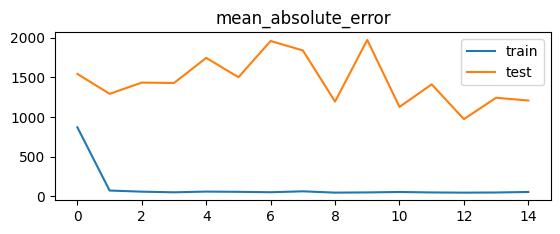

In [25]:
#vemos la grafica de entrenamiento
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_model1_LSTM.history['mean_absolute_error'], label='train')
plt.plot(history_model1_LSTM.history['val_mean_absolute_error'], label='test')
plt.legend()

Ahora vamos a mejorar el modelo añadiendole mas capas y dropout para evitar el sobre ajuste y todo esto para intentar mejorar el resultado

In [26]:
model2_LSTM=Sequential()
model2_LSTM.add(LSTM(32,activation='relu',  input_shape = (X_train_shape.shape[1], X_train_shape.shape[2]),kernel_regularizer=l1(0.01), return_sequences= True))
model2_LSTM.add(Dropout(0.2))
model2_LSTM.add(LSTM(16,activation='relu',  kernel_regularizer=l1(0.01)))
model2_LSTM.add(Dropout(0.2))
model2_LSTM.add(Dense(1))

model2_LSTM.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_model2_LSTM = model2_LSTM.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape),steps_per_epoch=1000, epochs=15, batch_size = 32)

Epoch 1/15
1000/1000 [==============================] - 57s 53ms/step - loss: 9490255.0000 - mean_absolute_error: 1972.7506 - mean_absolute_percentage_error: 33.8657 - val_loss: 11089798.0000 - val_mean_absolute_error: 2574.0117 - val_mean_absolute_percentage_error: 9.9647
Epoch 2/15
1000/1000 [==============================] - 51s 51ms/step - loss: 1635696.8750 - mean_absolute_error: 919.3504 - mean_absolute_percentage_error: 14.8439 - val_loss: 57032216.0000 - val_mean_absolute_error: 4642.9321 - val_mean_absolute_percentage_error: 12.6902
Epoch 3/15
1000/1000 [==============================] - 53s 53ms/step - loss: 1536617.8750 - mean_absolute_error: 891.0452 - mean_absolute_percentage_error: 14.1251 - val_loss: 53588008.0000 - val_mean_absolute_error: 4252.3042 - val_mean_absolute_percentage_error: 10.6477
Epoch 4/15
1000/1000 [==============================] - 52s 52ms/step - loss: 1564508.8750 - mean_absolute_error: 902.9069 - mean_absolute_percentage_error: 14.4121 - val_loss: 6

In [27]:
#evaluamos el modelo
ypred_model2_LSTM = model2_LSTM.predict(X_test_shape)

_, mae_tr, mape_tr = model2_LSTM.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = model2_LSTM.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

12195/12195 [==============================] - 46s 4ms/step - loss: 39251228.0000 - mean_absolute_error: 3906.6128 - mean_absolute_percentage_error: 10.7769
MAE train: 167.00; MAPE train: 2.68
MAE test: 3906.61; MAPE test: 10.78


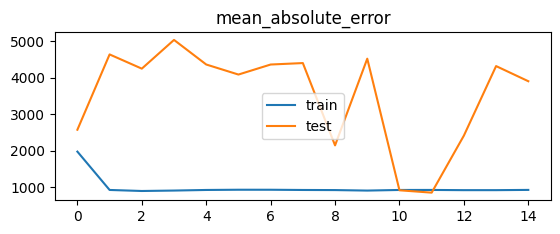

In [28]:
#vemos la grafica de entrenamiento
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_model2_LSTM.history['mean_absolute_error'], label='train')
plt.plot(history_model2_LSTM.history['val_mean_absolute_error'], label='test')
plt.legend()

Pasa lo mismo que con las redes recurrentes,viendo ambos casos vemos que la red más simple model1_LSTM es la más adecuada para los datos y la tarea específica, lo que lleva a un entrenamiento más efectivo. El modelo más complejo model2_LSTM es demasiado complejo para el problema en cuestión. Además, las complejidades añadidas en model2_LSTM podrían hacer que el modelo requiera más datos o más tiempo de entrenamiento para alcanzar su potencial.

## Redes GRU

Las redes de Unidades Recurrentes Cerradas (Gated Recurrent Units o GRU) son una variante de las redes neuronales recurrentes que también están diseñadas para trabajar con secuencias de información y abordar el problema de las dependencias a largo plazo que se presenta en las RNNs tradicionales. Aquí te detallo las características principales de las GRUs:

1.Estructura simplificada: A diferencia de las LSTMs, las GRUs tienen una estructura más simple con solo dos puertas, lo que las hace más fáciles de computar y, en algunos casos, más eficientes:

-Puerta de actualización (update gate): Decide cuánto del estado anterior se debe mantener y cuánto del nuevo estado calculado se debe utilizar.

-Puerta de reinicio (reset gate): Determina cuánto del estado anterior se debe olvidar.

2.Flexibilidad: Las GRUs son capaces de adaptarse a diferentes tipos de problemas de secuencia y han demostrado ser eficaces en tareas como el modelado de lenguaje y la traducción automática.

3.Estado oculto: Al igual que las LSTMs, las GRUs utilizan estados ocultos para transferir información a través de pasos de tiempo, pero lo hacen de manera ligeramente diferente debido a su arquitectura de puertas simplificada.

4.Entrenamiento: Las GRUs también utilizan el algoritmo de backpropagation through time (BPTT) para el entrenamiento, lo que les permite aprender a través de largas secuencias de información.

5.Aplicaciones: Las GRUs se emplean en muchos de los mismos contextos que las LSTMs, como el procesamiento de lenguaje natural, la generación de texto, y el análisis de series temporales.

6.Comparación con LSTMs: No hay una regla definitiva sobre cuándo usar GRUs en lugar de LSTMs. La elección suele basarse en el rendimiento en un conjunto de datos y tarea específicos; en algunos casos, las GRUs superan a las LSTMs y viceversa.

7.Eficiencia: Debido a su menor complejidad, las GRUs pueden ser más eficientes en términos de memoria y tiempo de cálculo, lo que puede ser una ventaja significativa cuando se trabaja con recursos limitados o se requiere rapidez en el procesamiento.

Las GRUs son, por tanto, una alternativa poderosa y eficiente para el modelado de secuencias, que ofrece algunas ventajas en cuanto a simplicidad y eficiencia computacional en comparación con las LSTMs, aunque la elección entre GRU y LSTM a menudo depende del contexto específico y de los resultados de experimentación en los datos pertinentes

In [29]:
model_GRU=Sequential()
model_GRU.add(GRU(32,activation='relu',  input_shape = (X_train_shape.shape[1], X_train_shape.shape[2]),kernel_regularizer=l1(0.01)))
model_GRU.add(Dense(1))

model_GRU.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_model_GRU = model_GRU.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape), epochs=15, batch_size = 32)

Epoch 1/15
54817/54817 [==============================] - 400s 7ms/step - loss: 91706.1016 - mean_absolute_error: 58.6159 - mean_absolute_percentage_error: 1.0545 - val_loss: 24906.0957 - val_mean_absolute_error: 92.8957 - val_mean_absolute_percentage_error: 0.3730
Epoch 2/15
54817/54817 [==============================] - 398s 7ms/step - loss: 3816.8396 - mean_absolute_error: 41.0205 - mean_absolute_percentage_error: 0.7057 - val_loss: 166461.6406 - val_mean_absolute_error: 218.3128 - val_mean_absolute_percentage_error: 0.5915
Epoch 3/15
54817/54817 [==============================] - 386s 7ms/step - loss: 3427.0178 - mean_absolute_error: 38.5798 - mean_absolute_percentage_error: 0.6570 - val_loss: 879400.8750 - val_mean_absolute_error: 486.9953 - val_mean_absolute_percentage_error: 1.0885
Epoch 4/15
54817/54817 [==============================] - 409s 7ms/step - loss: 3083.5344 - mean_absolute_error: 36.8230 - mean_absolute_percentage_error: 0.6250 - val_loss: 1682745.5000 - val_mean_ab

In [30]:
#evaluamos el modelo
ypred_model_GRU = model_GRU.predict(X_test_shape)

_, mae_tr, mape_tr = model_GRU.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = model_GRU.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

12195/12195 [==============================] - 32s 3ms/step - loss: 668223.2500 - mean_absolute_error: 446.7369 - mean_absolute_percentage_error: 1.0560
MAE train: 17.64; MAPE train: 0.27
MAE test: 446.74; MAPE test: 1.06


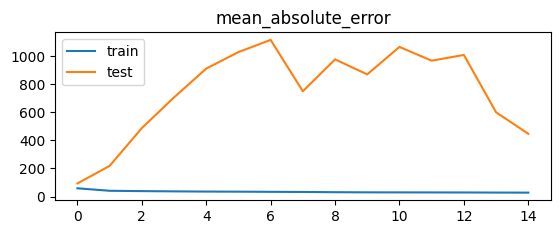

In [31]:
#vemos la grafica de entrenamiento
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_model_GRU.history['mean_absolute_error'], label='train')
plt.plot(history_model_GRU.history['val_mean_absolute_error'], label='test')
plt.legend()

## Compracion de modelos y conclusion

Comparando los modelos tenemos la siguiente conclusión:

-Para empezar en esta comparación solo compararemos los modelos con las redes simples puesto que hemos visto que tanto con la red recurrente compleja como la red LSTM compleja son demasiado complejos para el problema y eso que solamente hemos añadido una capa mas de cada tipo y dos dropout.

El orden de de mejor a peor de los modelos de redes simples es el siguiente:

1.**Redes GRU:**

-MAE train: 17.64; MAPE train: 0.27

-MAE test: 446.74; MAPE test: 1.06

Las GRU tienen el mejor rendimiento en la muestra de entrenamiento y, aunque su error aumenta en la muestra de prueba, sigue siendo significativamente más bajo que en las RNN y las LSTM. Esto sugiere que las GRU están equilibrando mejor la capacidad de ajuste y generalización.

2.**Redes recurrentes**

-MAE train: 28.65; MAPE train: 0.51

-MAE test: 228.27; MAPE test: 0.70

Las RNN tienen un rendimiento aceptable en la muestra de entrenamiento, pero su rendimiento disminuye un poco en la muestra de prueba. El modelo aprende muy bien los datos de entrenamiento.

3.**Redes LSTM**

-MAE train: 55.33; MAPE train: 1.29

-MAE test: 1208.55; MAPE test: 2.86

Las LSTM presentan el peor rendimiento tanto en entrenamiento como en prueba, lo que podría indicar que el modelo es demasiado complejo para los datos.